O objetivo desse projeto foi realizar web scrapping da página com os [100 livros mais vendidos pela Amazon](https://www.amazon.com.br/gp/bestsellers/books/?ie=UTF8&ref_=sv_b_2) coletando informações como nome do livro e autor, preço e avaliações. O resultado final foi gravado em um arquivo estruturado no formato csv

Obs: 
- Existem duas páginas com 50 livros cada
- Cada página faz uso de JavaScript dinâmico, ou seja o carregamento dos livros é gradual com a rolagem da barra lateral do navegador
- Não há padrão entre as URLs das páginas.

Perpsectivas:
Realizar task a ser executadas de tempos em tempos e alerta por email

# Pacotes Utilizados

In [12]:
import requests
from bs4 import BeautifulSoup
import re

from selenium import webdriver
import time
from selenium.webdriver.common.by import By

import pandas as pd

pd.set_option('display.max_rows', None)

from IPython.display import Image

# Obtendo Acesso ao Site da Amazon e Coletando HTML da Página

Inicialmente, vamos enviar uma solicitação HTTP para leitura da página WEB por meio da biblioteca request. Aqui é interessante passar um header indicando que a solicitação vem de um navegador, pois pode acontecer da requisição ser negada caso o servidor identifique que vem de um bot.

In [14]:
url = "https://www.amazon.com.br/gp/bestsellers/books/?ie=UTF8&ref_=sv_b_2"

#what is my user agent
header = {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36"}

In [ ]:
site = requests.get(url, headers = header)

In [4]:
site

<Response [200]>

Como a requisição foi bem sucessida (código 200), podemos passar o contéudo da página para um objeto do BeatifulSoup que irá fazer o parser desse HTML permitindo navegar pela sua estrutura de forma simples.

In [6]:
soup = BeautifulSoup(site.content, "html.parser")

# Localizar Informações na Página

Vamos buscar as seguintes informações referente aos livros:
- Posição no Ranking
- Nome do Livro
- Autor
- Preço
- Número de Estrelas
- Total de Avaliações Concedidas

A ideia é usar um livro como teste para encontrar em quais tags estão essas informações identificando um padrão de busca que possa ser extendido para os demais livros de forma automatizada. Também, para cada informação, definirei funções afim de escalar a busca com maior facilidade, sem precisar repetir código na versão final.

Utilizando o inspecionar do navegador é possível obervar que cada livro está dentro de uma tag div com id "gridItemRoot".

In [3]:
Image(url="images/tag_grid.png")

Assim, podemos obter as informações de um único livro com:

In [ ]:
livro_teste = soup.find("div", {"id":"gridItemRoot"})

Agora, vamos extrair as características desse livro

## Posição no Ranking

In [4]:
Image(url="images/tag_rank.png")

In [9]:
# Posição no Ranking
livro_teste.find("span", class_ = "zg-bdg-text").get_text()[1:]

'1'

In [3]:
def get_ranking(livro):
    return livro.find("span", class_ = "zg-bdg-text").get_text()[1:]

## Nome do Livro

In [5]:
Image(url="images/tag_book_name.png")

Como o nome da classe é muito grande, realizei uma busca aproximada com regex pelo termo "clamp-1" que se repete independente do livro. 

In [11]:
# Nome do Livro
livro_teste.find("div", class_ = re.compile("clamp-1")).get_text()

'É Assim que Acaba'

In [4]:
def get_book_name(livro):
    return livro.find("div", class_ = re.compile("clamp-1")).get_text()

## Autor

In [6]:
Image(url="images/tag_author_name.png")

In [13]:
livro_teste.find("div", class_ = "a-row a-size-small").get_text()

'Colleen Hoover'

In [5]:
def get_author_name(livro):
    return livro.find("div", class_ = "a-row a-size-small").get_text()    

Para os itens abaixo, alguns livros não mostram. Por isso, usei um try except para evitar explpdir uma mensagem de erro tendo em vista que o retorno do find seria nONE.

## Preço

In [7]:
Image(url="images/tag_price.png")

In [14]:
float(livro_teste.find("span", class_ = re.compile("price")).get_text().replace(",", ".")[3:])

37.42

In [6]:
def get_price(livro):
    try:
        price = float(livro.find("span", class_ = re.compile("price")).get_text().replace(",", ".")[3:])
    except AttributeError:
        price = 0   
    return price  

## Estrelas

In [8]:
Image(url="images/tag_stars.png")

In [21]:
#estrelas
float(livro_teste.find("a", {"class":"a-link-normal", "title":re.compile("estrelas")}).get_text()[0:3].replace(",","."))

4.8

In [7]:
def get_stars(livro):
    try:
        stars = float(livro.find("a", {"class":"a-link-normal", "title":re.compile("estrelas")}).get_text()[0:3].replace(",","."))
    except AttributeError:
        stars = 0
    return stars

## Avaliações

In [9]:
Image(url="images/tag_number_review.png")

In [ ]:
# numero avaliações
int(livro_teste.find(lambda tag: tag.name == 'span' and tag.get('class') == ['a-size-small']).get_text().replace(".",""))

15271

Aqui, usei uma função anonima para retornar exatamente a tag span com classe "a-size-small", pois em alguns livros há uma outra tag span com uma classe "a-size-small a-color-base" acima desta. Se usarmos find("span", "a-size-small") os elementos contidos nessa segunda tag é que são retornados.

In [8]:
def get_aval_numbers(livro):
    try:
        aval = int(livro.find(lambda tag: tag.name == 'span' and tag.get('class') == ['a-size-small']).get_text().replace(".",""))
    except AttributeError:
        aval = 0
    return aval

Agora que conseguimos recuperar as informações de um único livro basta repetir o procedimento para os demais

# Obter Informação de Todos os Livros da Página

Diferente do método find que retorna apenas uma única ocorrência (a primeira),o find_all retorna todas as ocorrências encontradas em uma lista 

In [25]:
#Encontrado todos os grids na página
livros = soup.find_all("div", {"id":"gridItemRoot"})

In [24]:
len(livros)

30

O esperado seria obter 50 livros, mas apenas 30 foram retornados. Isso aconteceu porque a página faz uso de JavaScript dinâmico. Ao abrir a página por um navegador, é possivel observar que apenas os 30 prineiros livros são renderizados e os demais gradativamente com a rolagem da barra de scroll do navegador. Precisamos então antes de coletar o conteudo descer até o final da página e aguardar que todos os livros carreguem. Faremos isso com o auxílio do [Selenium](https://www.selenium.dev/).

In [27]:
#instância do browser
driver = webdriver.Firefox()

#acessar URL
driver.get(url)

#rolar totalmente o scroll para baixo
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

#sleep para aguardar a página carregar totalmente
time.sleep(10)

#obter conteudo da página
page_source = driver.page_source

#fechar o browser
driver.quit()

Como não executamos o webdriver em modo silencioso é possível visualizar o browser realizar as tarefas automaticamente. Depois, novamente passamos o conteúdo da página para o BeatifulSoup.

In [29]:
soup = BeautifulSoup(page_source, "html.parser")

In [30]:
livros = soup.find_all("div", {"id":"gridItemRoot"})

In [31]:
len(livros)

50

Agora sim temos todos os 50 livros da primeira página! Como o URL da página 2 é totalmente diferente, não podemos iterar por meio de um loop alterando o valor de i de 1 para 2, por exemplo. É necessário efetuar um click no botão "próxima página" e só então iniciar a coleta do contéudo.

Basicamente essas são as etapas a ser realizadas:
- 1: acessar URL da página 1
- 2: rolar o scroll da página para baixo até o fim
- 3: aguardar um pequeno período para a página renderizar totalmente
- 4: obter conteúdo HTML da página 1
- 5: efetuar click no botão "próxima página" para acessar a página 2
- 6: rolar o scroll da página para baixo até o fim
- 7: aguardar um pequeno período para a página renderizar totalmente
- 8: obter conteúdo HTML da página 2

In [22]:
html_pages = []

#instância do browser
driver = webdriver.Firefox()

#acessar URL
driver.get(url)

#rolar totalmente o scroll para baixo
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

#sleep para aguardar a página carregar totalmente
time.sleep(10)

#obter conteudo da página
html_pages.append(driver.page_source)

#avançar para proxima pagina
next_button = driver.find_element(By.CLASS_NAME, "a-normal")
next_button.click()
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(10)

html_pages.append(driver.page_source)

#fechar o browser
driver.quit()

In [26]:
len(html_pages)

2

Agora que temos o HTML das duas páginas, basta apenas criar uma estrutura para armazenar os resultados e ir preenchendo-as com as funções determinadas anteriormentes por meio de um loop para cada página.

In [10]:
result = {"Posição":[],
         "Livro":[],
         "Autor":[],
         "Preço":[],
         "Avaliação":[],
         "Número Reviews":[]}

In [11]:
for i in range(len(html_pages)):
    soup = BeautifulSoup(html_pages[i], "html.parser")
    livros = soup.find_all("div", {"id":"gridItemRoot"})
    
    for livro in livros:
        result["Posição"].append(get_ranking(livro))
        result["Livro"].append(get_book_name(livro))
        result["Autor"].append(get_author_name(livro))
        result["Preço"].append(get_price(livro))
        result["Avaliação"].append(get_stars(livro))
        result["Número Reviews"].append(get_aval_numbers(livro))
    

In [12]:
pd.DataFrame(result).shape

(100, 6)

Temos todos os 100 livros com as 6 informações buscadas. Vamos gravar e visualizar o resultado em um DataFrame

In [13]:
df = pd.DataFrame(result)

In [14]:
df.head()

,Posição,Livro,Autor,Preço,Avaliação,Número Reviews
0,1,É Assim que Acaba,Colleen Hoover,37.42,4.8,15273
1,2,Amor & Gelato: 1,Jenna Evans Welch,30.00,4.7,11300
2,3,A garota do lago,Charlie Donlea,8.50,4.7,25492
3,4,Spy X Family Vol. 7,Tatsuya Endou,23.40,4.9,325
4,5,PING PONG VOL. 1,TAYO MATSUMOTO,67.40,4.8,90


In [28]:
df = pd.read_csv("top100_books_amazon.csv")

# Rápida Análise Exploratória

In [29]:
serie = df["Autor"].value_counts() 

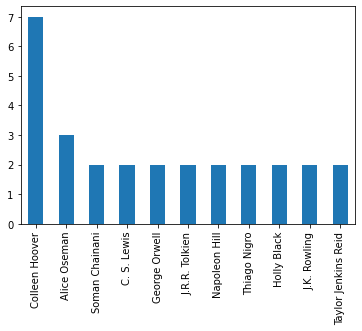

In [33]:
serie[serie > 1].plot.bar();

Dentre os autores com mais livros no top 100, se destaca a Collen Hoover com nada mais nada menos do que 7 livros!! Também há a presença de um brasileiro na lista, o criador do maior canal de educação financeira do Brasil, Primo Rico, Thiago Nigro, além de outros autores famosos como J.K.Rowling, Tolkien e George Orwell.

In [16]:
df[df["Autor"] == "Colleen Hoover"]

,Posição,Livro,Autor,Preço,Avaliação,Número Reviews
0,1,É Assim que Acaba,Colleen Hoover,37.42,4.8,15273
15,16,Até o verão terminar,Colleen Hoover,28.70,4.7,2789
19,20,Verity,Colleen Hoover,27.90,4.7,7550
23,24,Todas as suas (im)perfeições,Colleen Hoover,37.42,4.8,8022
31,32,"Novembro, 9",Colleen Hoover,27.90,4.7,4597
39,40,O lado feio do amor,Colleen Hoover,31.20,4.7,10003
48,49,As mil partes do meu coração,Colleen Hoover,28.90,4.7,2979


Avaliando pelo os titulos dos livros, a Collen Hoover parece ser uma atriz de romances. Assim, faz sentido esse alto número de vendas tendo em vista que essa análise foi feita próximo ao dia dos namorados e geralmente a Amazon faz promoções de livros em datas temáticas.

In [22]:
df[df["Autor"] == "George Orwell"]

,Posição,Livro,Autor,Preço,Avaliação,Número Reviews
25,26,As obras revolucionárias de George Orwell - Bo...,George Orwell,22.9,4.8,6553
57,58,A revolução dos bichos: Um conto de fadas,George Orwell,14.1,4.9,28075


George Orwell possui dois livros dentre os mais vendidos, sendo um deles um box contendo 3 livros (A revolução dos bixos, 1984 e Dentro da baleia e outros ensaios)

In [23]:
mais_caros = df["Preço"].sort_values(ascending = False)[0:10].index
df.loc[mais_caros,:]

,Posição,Livro,Autor,Preço,Avaliação,Número Reviews
62,63,Box Percy Jackson e os Olimpianos - Capa Nova:...,Rick Riordan,161.90,4.8,9821
83,84,Box Trilogia O Senhor dos Anéis,J.R.R. Tolkien,105.90,4.8,12912
98,99,Box O povo do ar - acompanha brindes,Holly Black,105.70,4.8,3616
51,52,"Cabeça Fria, Coração Quente","Vitor Castanheira Abel Ferreira, Carlos Martin...",70.99,4.9,1439
4,5,PING PONG VOL. 1,TAYO MATSUMOTO,67.40,4.8,90
44,45,AS 48 LEIS DO PODER (CAPA DURA),ROBERT GREENE,62.90,4.8,2148
72,73,Grama (Reimpressão),Keum Suk Gendry-Kim,59.40,4.9,1670
81,82,Laurentino Gomes,Laurentino Gomes,59.40,0.0,0
90,91,Rápido e devagar: Duas formas de pensar,Daniel Kahneman,55.94,4.7,8020
76,77,Comunicação não violenta - Nova edição: Técnic...,Marshall B. Rosenberg,49.90,4.8,838


Dentre os livros mais caros, há uma predominancia de boxes, que geralmente são vendidos por um valor mais alto sendo atrativos para colecionadores devido a presença de brindes, encartes ou ilustrações extras. Também temos a bibliografia do português Abel Ferreira, atualmente técnico do Palmeiras por 80 reais, um pouco salgado para uma bibliografia na minha opinião.

In [24]:
mais_avaliados = df["Número Reviews"].sort_values(ascending = False)[0:10].index
df.loc[mais_avaliados,:]

,Posição,Livro,Autor,Preço,Avaliação,Número Reviews
57,58,A revolução dos bichos: Um conto de fadas,George Orwell,14.10,4.9,28075
2,3,A garota do lago,Charlie Donlea,8.50,4.7,25492
20,21,Torto arado,Itamar Vieira Junior,36.51,4.8,22718
10,11,Mais esperto que o Diabo: O mistério revelado ...,Napoleon Hill,23.78,4.7,22451
12,13,Mulheres que correm com os lobos,Clarissa Pinkola Estés,34.90,4.8,21922
21,22,Do Mil ao Milhão. Sem Cortar o Cafezinho.,Thiago Nigro,17.90,4.7,21770
17,18,Os sete maridos de Evelyn Hugo,Taylor Jenkins Reid,34.84,4.8,20470
71,72,O morro dos ventos uivantes,Emily Brontë,13.60,4.6,19293
13,14,Os segredos da mente milionária: Aprenda a enr...,T. Harv Eker,29.90,4.8,18254
32,33,O poder do hábito,Charles Duhigg,47.90,4.8,18205


Também podemos visualizar os livros mais avaliados pelos compradores.

E por fim salvar o arquivo em formato csv

In [25]:
df.to_csv("top100_books_amazon.csv", index=False)